# Capstone 2: Data Wrangling - Walter Piper - Take 2 (Introducing abstractions)

# Data Collection - WESAD dataset

##### Downloaded WESAD dataset, then unzipped the main zip file, then unzipped each 'SX_E4_Data.zip'

##### Link to the dataset: https://uni-siegen.sciebo.de/s/pYjSgfOVs6Ntahr/download
##### The zip-file also contains a dataset description file (readme.pdf).

##### UCI Repository description at http://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29#
##### Original paper: “Introducing WESAD, a Multimodal Dataset for Wearable Stress and Affect Detection” https://www.eti.uni-siegen.de/ubicomp/papers/ubi_icmi2018.pdf

# Note to reader:
#### For each subject, this dataset contains data from 2 physiology sensor devices, 5 sets of questionnaires, and a small number of person-level variables.
#### This notebook will check the integrity and accessibility of this data.
##### .pkl files encode dictionaries with 3 top-level keys: 
* 'subject'= string: subject ID 'SX' or 'SXX', 
* 'label'= numpy array: experimental task code per time point (700Hz)
* 'signal'= dictionary with 2 keys
** 'chest'= dictionary with 6 keys: RespiBAN device signals (all 700Hz)
** * 'ECG': electrocardiography
** * 'EMG': electromyography
** * 'EDA': electrodermal activity
** * 'Temp': temperature measurements
** * 'Resp': respiration
** * 'ACC': accelerometer
** 'wrist'= dictionary with 4 keys: EMPATICA E4 device signals
** * 'ACC': accelerometer (32Hz)
** * 'BVP': blood volume of pulse (64Hz)
** * 'EDA': electrodermal activity (4Hz)
** * 'TEMP': temperature measurements (4Hz)

##### I also combined self-report questionnaires for a given subject into single DataFrames, then saved that as interim data
##### I also translated S_readme.txt files into a single dictionary for each subject, then saved that as interim data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import json

# Construct 3 dictionaries, each containing file paths for all subjects for a given data type.

In [10]:
# Check for data files from all 15 subjects
path = 'D:\\Springboard\\Capstone2\\WESAD\\Capstone2\\data\\raw\\'
#Subjects S1 and S12 had sensor errors and are not included in download
pkl_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*.pkl', recursive=True)[0] for i in range(2,18,1) if i != 12} #Signal data
quest_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*.csv', recursive=True)[0] for i in range(2,18,1) if i != 12} #Questionnaires
subjinfo_dict = {'S'+str(i) : glob(path+'S'+str(i)+'\\S'+str(i)+'*readme.txt', recursive=True)[0] for i in range(2,18,1) if i != 12} #Extra self-report data, collected start of session

for dictionary, name in zip([pkl_dict, quest_dict, subjinfo_dict], ['signal data', 'affective questionnaires', 'subject-level info']):
    print(name,':')
    for subjectID, pathstring in dictionary.items():
        print(subjectID,': ',pathstring)
    print('\n')

signal data :
S2 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S2\S2.pkl
S3 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S3\S3.pkl
S4 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S4\S4.pkl
S5 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S5\S5.pkl
S6 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S6\S6.pkl
S7 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S7\S7.pkl
S8 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S8\S8.pkl
S9 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S9\S9.pkl
S10 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S10\S10.pkl
S11 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S11\S11.pkl
S13 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S13\S13.pkl
S14 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S14\S14.pkl
S15 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S15\S15.pkl
S16 :  D:\Springboard\Capstone2\WESAD\Capstone2\data\raw\S16\S16.pkl
S17 :  D:\Springboard\Capstone2\WESAD\Capsto

# Examine .pkl files (containing physiology recordings) for each subject

In [174]:
def check_pkl_raw(Subj_ID, pkl_filepaths, return_data=False):
    """
    Check the integrity of raw time series data for a given subject.
    Input: 
        Subj_ID: string ('S2'-'S17')
        pkl_filepaths: dictionary of paths with Subj_ID as key
        return_data: Boolean. Indicates whether data should be returned at end of function
    Output (if requested by return_data keyword):
        dict_signal_single_subject: Dictionary containing data for the subject Subj_ID. 
    """    
    # LOAD DICTIONARY FROM PKL FILE
    dict_signal_single_subject = pd.read_pickle(pkl_filepaths[Subj_ID]) # Load pickle file
    print('Dictionary from .pkl file has keys:',dict_signal_single_subject.keys())
    # Check type, length of each key's value
    for key in dict_signal_single_subject.keys():
        print(key, ' is type:' , type(dict_signal_single_subject[key]), ' with length:', len(dict_signal_single_subject[key]))
        
    print('\n')
    print('SUBJECT #:',dict_signal_single_subject['subject'])
    
    # LABEL VALUES SHOW TEMPORAL STRUCTURE OF EXPERIMENT
    print('\n')
    print('LABEL unique values:',np.unique(dict_signal_single_subject['label'])) 
    # readme.pdf described label array as labels for the different experimental segments within the research design
    label_dict = {'0':'not defined/transient' ,'1':'baseline' ,'2':'stress' ,'3':'amusement' ,'4':'meditation' ,'5':'ignore' ,'6':'ignore' ,'7':'ignore' }
    print(label_dict)
    plt.plot(np.linspace(0, 6079, len(dict_signal_single_subject['label'])), dict_signal_single_subject['label'])
    plt.title(dict_signal_single_subject['subject']+' label array')
    plt.xlabel('time (s)')
    plt.ylabel('LABEL CODE')
    plt.show()
    
    # EXAMINE PHYSIOLOGY SIGNAL ARRAYS
    print('\n')
    print('SIGNAL KEYS:',dict_signal_single_subject['signal'].keys())
    print('chest:', type(dict_signal_single_subject['signal']['chest']), 'has keys:', dict_signal_single_subject['signal']['chest'].keys()) # Chest = RespiBAN data
    print('wrist:',type(dict_signal_single_subject['signal']['wrist']), 'has keys:', dict_signal_single_subject['signal']['wrist'].keys()) # Wrist = Empatica E4 data
    Wrist_Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4} # Frequency for Wrist device channels
    Chest_Hz_dict = {'ACC':700, 'ECG':700, 'EMG':700, 'EDA':700, 'Temp':700, 'Resp':700} # Frequency for Chest device channels
    # Plot histograms for each recording channel
    for device, device_name, Hz_dict in zip(['chest', 'wrist'], ['Chest (RespiBAN) sensor', 'Wrist (Empatica E4) sensor'], [Chest_Hz_dict, Wrist_Hz_dict]):
        print('\n',device_name)
        fig, axes = plt.subplots(1, len(dict_signal_single_subject['signal'][device].keys()), figsize=[16,2.5])
        for key, ax in zip(dict_signal_single_subject['signal'][device].keys(), axes):
            sig_array = dict_signal_single_subject['signal'][device][key]
            print(key, 'array has shape:', sig_array.shape, 'at',Hz_dict[key], 'Hz for a total of ', sig_array.shape[0]/Hz_dict[key],'seconds')
            sample = np.random.choice(sig_array.flatten(), size=10000)
            ax.hist(sample, bins=20)
            ax.set_title(key)
        fig.suptitle(device_name+'\nHistograms of 10000 randomly sampled datapoints')
        plt.tight_layout()
        plt.show()
    print('\n----------------------------------------------------------------------------\n')
    
    if return_data == True:
        return dict_signal_single_subject

In [175]:
def process_questionnaires(Subj_ID, question_filepaths, return_df=False, save_rootpath=None):
    """
    Combines experiment segment start/end times and all questionnaires into a single dataframe and plots questionnaire items.
    Input:
        Subj_ID - string (Subject ID)
        question_filepaths - dictionary (Subj_ID: filepaths)
        return_df=False - If True, returns a pandas DataFrame
        save_rootpath=None - If not None, saves .csv file.
    Output:
        Quest_df - pandas DataFrame
    """
    # Funky format: headers are on left and row lengths are uneven. Using csv module instead of pandas.
    import csv
    quest_dict = dict()
    repeated_measures = {'PANAS':0, 'STAI':0, 'DIM':0} #This will help in labeling the repeated measures
    # Converting the messy .csv file to a pandas-friendly format.
    with open(question_filepaths[Subj_ID], 'r') as quest_file:
        for row in csv.reader(quest_file, delimiter=';'):
            if '#' in row[0]:
                thisrow = [entry if '#' not in entry else entry[2:] for entry in row]
                stripped = False
                while stripped==False:
                    try: thisrow.remove('')
                    except: stripped = True
                if thisrow[0] in repeated_measures.keys():
                    thisrow[0] = thisrow[0] + '_' + quest_dict['ORDER'][repeated_measures[thisrow[0]]] #Renames index value with corresponding task
                    repeated_measures[thisrow[0].split('_')[0]] += 1
                row_header = thisrow[0]
                row_data = thisrow[1:]
                quest_dict[row_header] = row_data

    # Each experiment segment has a start and an end (in minutes)
    ORDER_df = pd.DataFrame(pd.Series(quest_dict['START'], index=quest_dict['ORDER'], name='START')).join(pd.Series(quest_dict['END'], index=quest_dict['ORDER'], name='END'))
    #print(ORDER_df) # Unit seems to be minutes
    
    # These lists represent items on questionnaires
    #PANAS is a 5 point scale (1-5)
    PANAS_Base_list = 'Active Distressed Interested Inspired Annoyed Strong Guilty Scared Hostile Excited Proud Irritable Enthusiastic Ashamed Alert Nervous Determined Attentive Jittery Afraid Stressed Frustrated Happy Sad'
    PANAS_Base_list = PANAS_Base_list.split(' ')
    PANAS_TSST_list = 'Active Distressed Interested Inspired Annoyed Strong Guilty Scared Hostile Excited Proud Irritable Enthusiastic Ashamed Alert Nervous Determined Attentive Jittery Afraid Stressed Frustrated Happy Angry Irritated Sad'
    PANAS_TSST_list = PANAS_TSST_list.split(' ')
    #STAI is a 4 point scale (1-4)
    STAI_list = ['I feel at ease', 'I feel nervous', 'I am jittery', 'I am relaxed', 'I am worried', 'I feel pleasant']
    #DIM/SAM is a 9 point scale (1-9)
    DIM_list = ['Valence', 'Arousal']
    #SSSQ is a 5 point scale (1-5)
    SSSQ_list = ['I was committed to attaining my performance goals', 'I wanted to succeed on the task', 'I was motivated to do the task',
                'I reflected about myself', 'I was worried about what other people think of me', 'I felt concerned about the impression I was making']

    PANAS_TSST = pd.Series(quest_dict['PANAS_TSST'], index=PANAS_TSST_list, name='TSST')
    PANAS_Base = pd.Series(quest_dict['PANAS_Base'], index=PANAS_Base_list, name='Base')
    PANAS_Medi1 = pd.Series(quest_dict['PANAS_Medi 1'], index=PANAS_Base_list, name='Medi 1')
    PANAS_Fun = pd.Series(quest_dict['PANAS_Fun'], index=PANAS_Base_list, name='Fun')
    PANAS_Medi2 = pd.Series(quest_dict['PANAS_Medi 2'], index=PANAS_Base_list, name='Medi 2')

    PANAS_df = pd.DataFrame(PANAS_Base).join(PANAS_TSST, how='right').join(PANAS_Medi1, how='left').join(PANAS_Fun, how='left').join(PANAS_Medi2, how='left')
    PANAS_df.index.name = 'PANAS'
    #print(PANAS_df)
    STAI_df = pd.DataFrame({key:value for key, value in quest_dict.items() if 'STAI' in key}, index=STAI_list)
    STAI_df.columns = quest_dict['ORDER'][:5]
    #print(STAI_df)
    DIM_df = pd.DataFrame({key:value for key, value in quest_dict.items() if 'DIM' in key}, index=DIM_list)
    DIM_df.columns = quest_dict['ORDER'][:5]
    #print(DIM_df)
    SSSQ_df = pd.Series(quest_dict['SSSQ'], index=SSSQ_list, name='TSST') # Ratings about TSST (public speaking task)
    #print(SSSQ_df)
    
    pd.set_option('display.max_columns', 50)  
    pd.set_option('display.width', 120)
    Quest_df = ORDER_df.iloc[:5,:].T.append(PANAS_df).append(STAI_df).append(DIM_df).append(pd.DataFrame(SSSQ_df)) # Append it all into one DataFrame
    Quest_df = Quest_df.replace('Nan', np.nan).astype(float) # Replace string with proper null value. This only occurs once, for subject S5.
    #print(Quest_df)
    
    #print(Quest_df.iloc[2:,:].info())
    
    Quest_df.iloc[2:,:].plot(figsize=[14,4], alpha=0.5, marker='o', linestyle=' ')
    plt.hlines([1,5,1,4,1,9,1,5],[-0.5,-0.5,25.5,25.5,31.5,31.5,33.5,33.5],[25.5,25.5,31.5,31.5,33.5,33.5,39.5,39.5], color='k', label='range boundaries')
    plt.legend()
    plt.xticks(range(len(Quest_df)-2), list(Quest_df.index)[2:], rotation=270)
    plt.title(Subj_ID+' Checking for out-of-range errors')
    
    plt.show()
    
    if save_rootpath != None:
        print('DATA SAVED TO '+save_rootpath)
        Quest_df.to_csv(save_rootpath+Subj_ID+'_Questions.csv') 
    print('\n-------------------------------------------------------\n')
    
    if return_df == True:
        return Quest_df

In [176]:
def process_subject_info(Subj_ID, subjinfo_dict, return_dict=False, save_rootpath=None):
    """
    Processes personal info obtained at beginning of experiment
    Input:
        SubjID - string (Subject ID)
        subjinfo_dict - dictionary (Subj_ID: filepaths)
        return_dict=False - If true, returns data in dictionary form.
        save_rootpath=None - If not none, saves data as .json file.
    Output:
        info_dict - dictionary
    """
    print(Subj_ID,'\n')
    info_dict = dict()
    with open(subjinfo_dict[Subj_ID], 'r') as file:
        lines = file.readlines()
        count = 0
        for line in lines:
            count += 1
            #print(line)
            if (count <= 6) and (count > 1):
                info_dict[str(line).split(':')[0]] = str(line).split(':')[1].strip()
            elif (count <= 14) and (count > 8):
                info_dict[str(line).split('?')[0]] = str(line).split('?')[1].strip()
            elif count > 16:
                info_dict['LINE_'+str(count)] = line

    #print('\n\n\n')
    for k, v in info_dict.items(): 
        print(k,':', v)
        
    if save_rootpath != None:
        import json
        with open(savepath+Subj_ID+"_info.json", "w") as outfile:  
            json.dump(info_dict, outfile) 
    print('\n---------------------------------------------------------------\n')
    
    if return_dict == True:
        return info_dict

In [180]:
check_pkl_raw?

Signature: check_pkl_raw(Subj_ID, pkl_filepaths, return_data=False)
Docstring:
Check the integrity of raw time series data for a given subject.
Input: 
    Subj_ID: string ('S2'-'S17')
    pkl_filepaths: dictionary of paths with Subj_ID as key
    return_data: Boolean. Indicates whether data should be returned at end of function
Output (if requested by return_data keyword):
    dict_signal_single_subject: Dictionary containing data for the subject Subj_ID. 
File:      d:\springboard\capstone2\wesad\capstone2\notebooks\<ipython-input-174-379e9d0dd7fe>
Type:      function


In [177]:
process_questionnaires?

Signature:
process_questionnaires(
    Subj_ID,
    question_filepaths,
    return_df=False,
    save_rootpath=None,
)
Docstring:
Combines experiment segment start/end times and all questionnaires into a single dataframe and plots questionnaire items.
Input:
    Subj_ID - string (Subject ID)
    question_filepaths - dictionary (Subj_ID: filepaths)
    return_df=False - If True, returns a pandas DataFrame
    save_rootpath=None - If not None, saves .csv file.
Output:
    Quest_df - pandas DataFrame
File:      d:\springboard\capstone2\wesad\capstone2\notebooks\<ipython-input-175-87b63349adc7>
Type:      function


In [126]:
process_subject_info?

Signature:
process_subject_info(
    Subj_ID,
    subjinfo_dict,
    return_dict=False,
    save_rootpath=None,
)
Docstring:
This replicates the earlier steps in the notebook to process personal info.
No output variable, but there is a saved file.
File:      d:\springboard\capstone2\wesad\capstone2\notebooks\<ipython-input-125-11748551c9ce>
Type:      function


Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4255300
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S2


LABEL unique values: [0 1 2 3 4 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


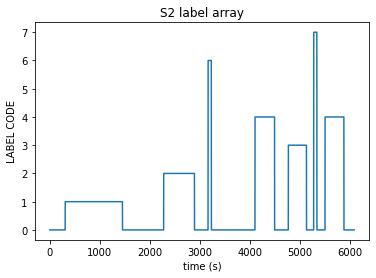



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4255300, 3) at 700 Hz for a total of  6079.0 seconds
ECG array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
EMG array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
EDA array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
Temp array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
Resp array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds


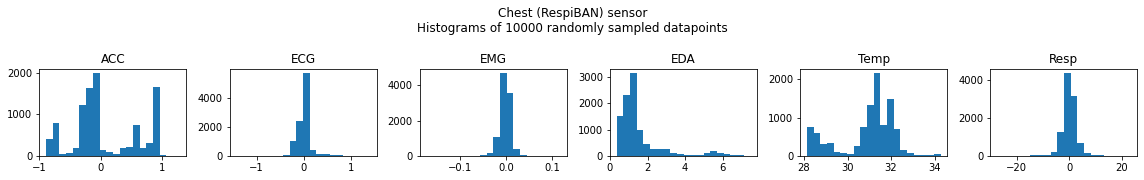


 Wrist (Empatica E4) sensor
ACC array has shape: (194528, 3) at 32 Hz for a total of  6079.0 seconds
BVP array has shape: (389056, 1) at 64 Hz for a total of  6079.0 seconds
EDA array has shape: (24316, 1) at 4 Hz for a total of  6079.0 seconds
TEMP array has shape: (24316, 1) at 4 Hz for a total of  6079.0 seconds


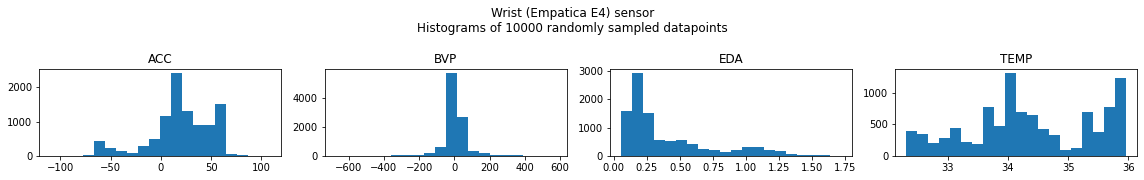


----------------------------------------------------------------------------



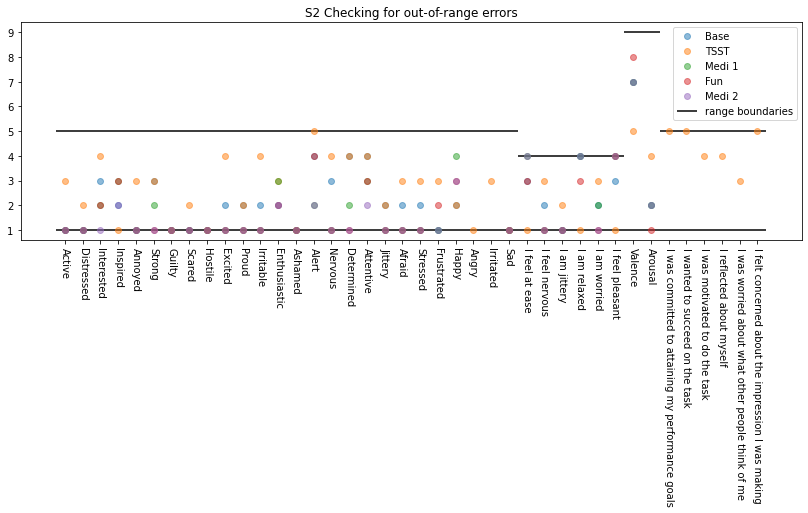


-------------------------------------------------------

S2 

Age : 27
Height (cm) : 175
Weight (kg) : 80
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4545100
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S3


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


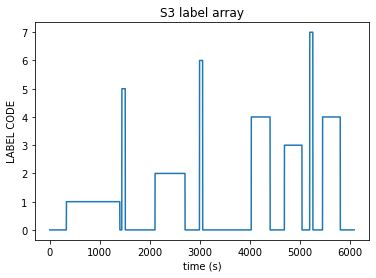



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4545100, 3) at 700 Hz for a total of  6493.0 seconds
ECG array has shape: (4545100, 1) at 700 Hz for a total of  6493.0 seconds
EMG array has shape: (4545100, 1) at 700 Hz for a total of  6493.0 seconds
EDA array has shape: (4545100, 1) at 700 Hz for a total of  6493.0 seconds
Temp array has shape: (4545100, 1) at 700 Hz for a total of  6493.0 seconds
Resp array has shape: (4545100, 1) at 700 Hz for a total of  6493.0 seconds


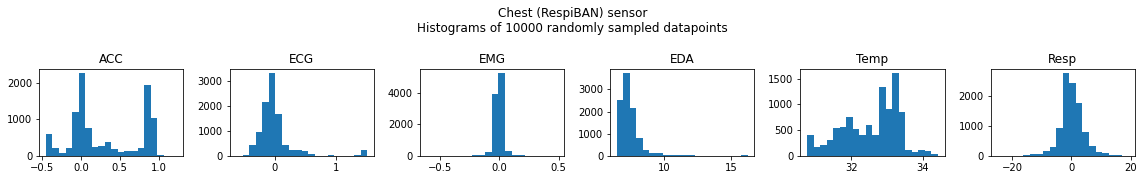


 Wrist (Empatica E4) sensor
ACC array has shape: (207776, 3) at 32 Hz for a total of  6493.0 seconds
BVP array has shape: (415552, 1) at 64 Hz for a total of  6493.0 seconds
EDA array has shape: (25972, 1) at 4 Hz for a total of  6493.0 seconds
TEMP array has shape: (25972, 1) at 4 Hz for a total of  6493.0 seconds


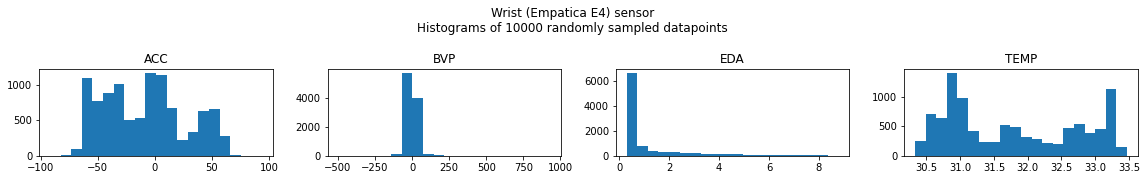


----------------------------------------------------------------------------



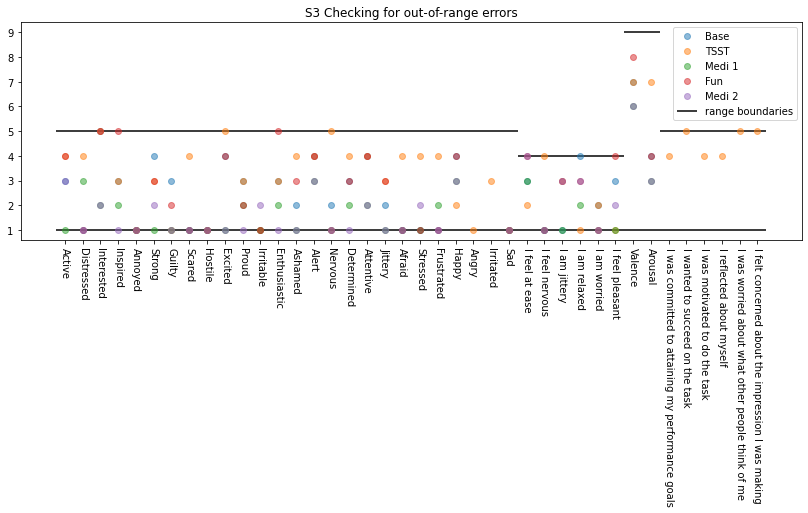


-------------------------------------------------------

S3 

Age : 27
Height (cm) : 173
Weight (kg) : 69
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : During the baseline condition, the subject was sitting in a sunny workplace.

LINE_18 : Subject provided a valence label of 7 after the stress condition, claiming that he was looking forward to the next condition and was therefore cheerful.


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4496100
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S4


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline

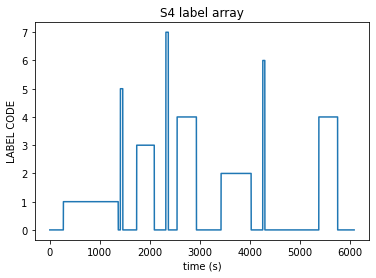



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4496100, 3) at 700 Hz for a total of  6423.0 seconds
ECG array has shape: (4496100, 1) at 700 Hz for a total of  6423.0 seconds
EMG array has shape: (4496100, 1) at 700 Hz for a total of  6423.0 seconds
EDA array has shape: (4496100, 1) at 700 Hz for a total of  6423.0 seconds
Temp array has shape: (4496100, 1) at 700 Hz for a total of  6423.0 seconds
Resp array has shape: (4496100, 1) at 700 Hz for a total of  6423.0 seconds


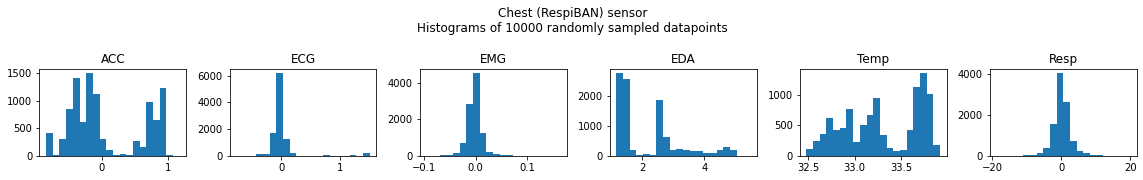


 Wrist (Empatica E4) sensor
ACC array has shape: (205536, 3) at 32 Hz for a total of  6423.0 seconds
BVP array has shape: (411072, 1) at 64 Hz for a total of  6423.0 seconds
EDA array has shape: (25692, 1) at 4 Hz for a total of  6423.0 seconds
TEMP array has shape: (25692, 1) at 4 Hz for a total of  6423.0 seconds


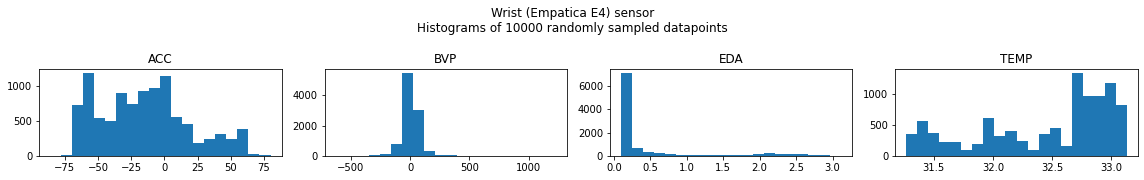


----------------------------------------------------------------------------



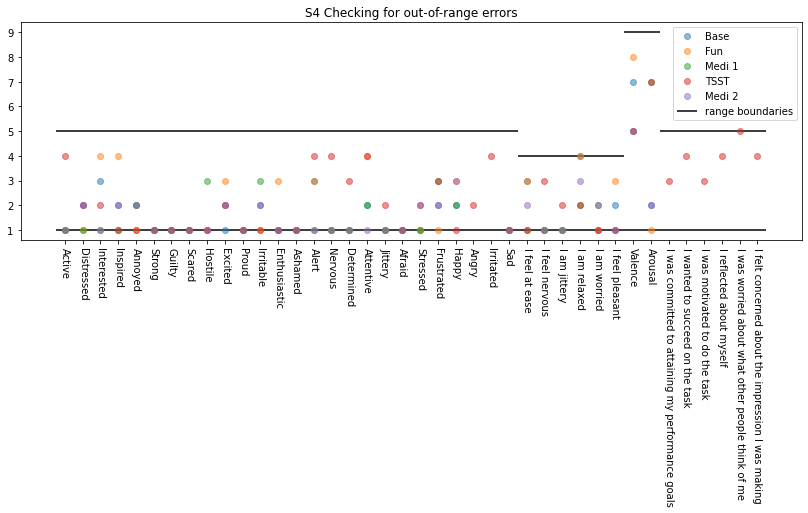


-------------------------------------------------------

S4 

Age : 25
Height (cm) : 175
Weight (kg) : 90
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4380600
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S5


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


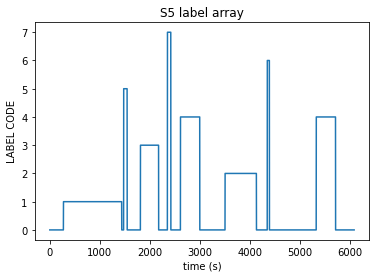



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4380600, 3) at 700 Hz for a total of  6258.0 seconds
ECG array has shape: (4380600, 1) at 700 Hz for a total of  6258.0 seconds
EMG array has shape: (4380600, 1) at 700 Hz for a total of  6258.0 seconds
EDA array has shape: (4380600, 1) at 700 Hz for a total of  6258.0 seconds
Temp array has shape: (4380600, 1) at 700 Hz for a total of  6258.0 seconds
Resp array has shape: (4380600, 1) at 700 Hz for a total of  6258.0 seconds


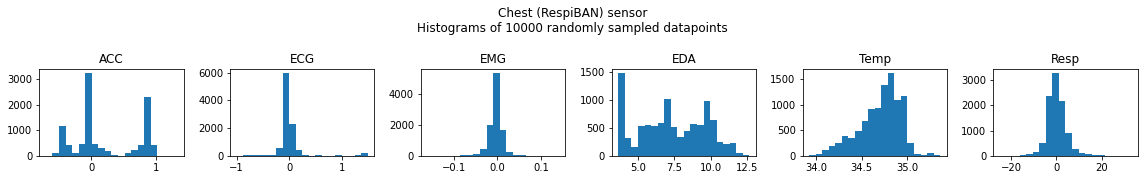


 Wrist (Empatica E4) sensor
ACC array has shape: (200256, 3) at 32 Hz for a total of  6258.0 seconds
BVP array has shape: (400512, 1) at 64 Hz for a total of  6258.0 seconds
EDA array has shape: (25032, 1) at 4 Hz for a total of  6258.0 seconds
TEMP array has shape: (25032, 1) at 4 Hz for a total of  6258.0 seconds


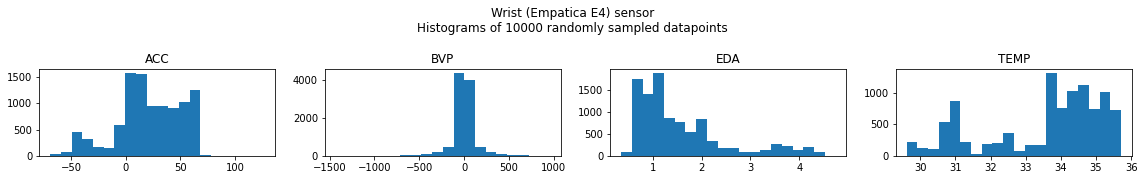


----------------------------------------------------------------------------



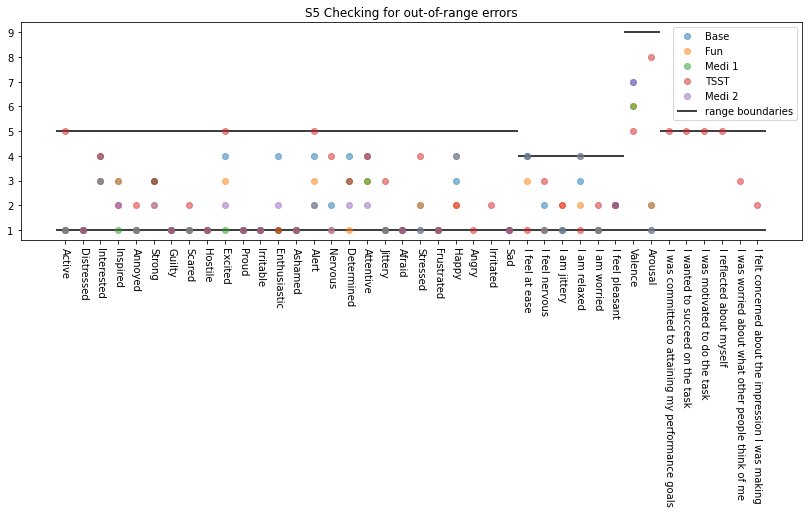


-------------------------------------------------------

S5 

Age : 35
Height (cm) : 189
Weight (kg) : 80
Gender : male
Dominant hand : right
Did you drink coffee today : YES
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : Subject might have fallen asleep during the first meditation.


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4949700
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S6


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


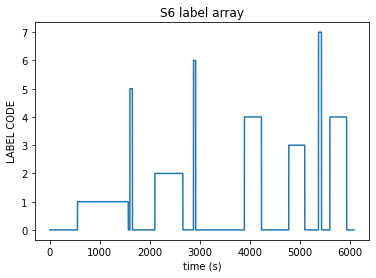



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4949700, 3) at 700 Hz for a total of  7071.0 seconds
ECG array has shape: (4949700, 1) at 700 Hz for a total of  7071.0 seconds
EMG array has shape: (4949700, 1) at 700 Hz for a total of  7071.0 seconds
EDA array has shape: (4949700, 1) at 700 Hz for a total of  7071.0 seconds
Temp array has shape: (4949700, 1) at 700 Hz for a total of  7071.0 seconds
Resp array has shape: (4949700, 1) at 700 Hz for a total of  7071.0 seconds


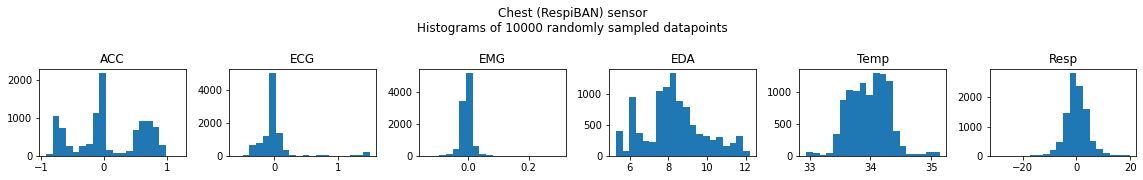


 Wrist (Empatica E4) sensor
ACC array has shape: (226272, 3) at 32 Hz for a total of  7071.0 seconds
BVP array has shape: (452544, 1) at 64 Hz for a total of  7071.0 seconds
EDA array has shape: (28284, 1) at 4 Hz for a total of  7071.0 seconds
TEMP array has shape: (28284, 1) at 4 Hz for a total of  7071.0 seconds


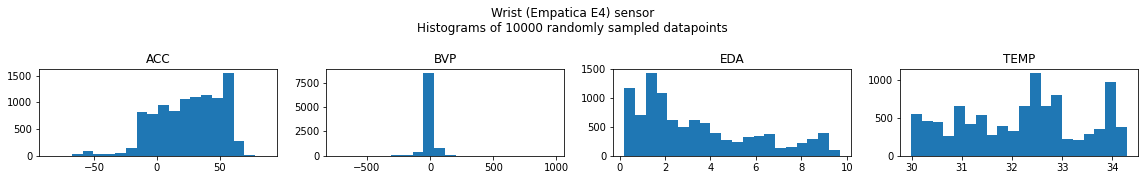


----------------------------------------------------------------------------



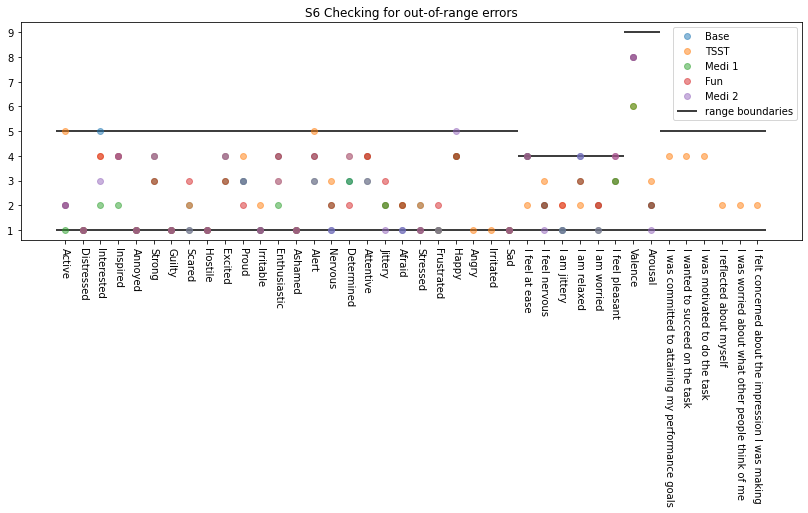


-------------------------------------------------------

S6 

Age : 27
Height (cm) : 170
Weight (kg) : 66
Gender : male
Dominant hand : right
Did you drink coffee today : YES
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : YES
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : Subject claimed that he had a stressfull week and hence the study was rather relaxing for him.

LINE_18 : Stress condition / TSST interview part: subject was not really stressed as he encountered many interviews in the weeks before.


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3666600
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S7


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2'

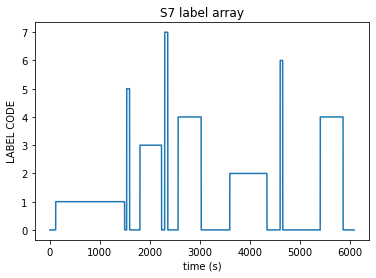



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3666600, 3) at 700 Hz for a total of  5238.0 seconds
ECG array has shape: (3666600, 1) at 700 Hz for a total of  5238.0 seconds
EMG array has shape: (3666600, 1) at 700 Hz for a total of  5238.0 seconds
EDA array has shape: (3666600, 1) at 700 Hz for a total of  5238.0 seconds
Temp array has shape: (3666600, 1) at 700 Hz for a total of  5238.0 seconds
Resp array has shape: (3666600, 1) at 700 Hz for a total of  5238.0 seconds


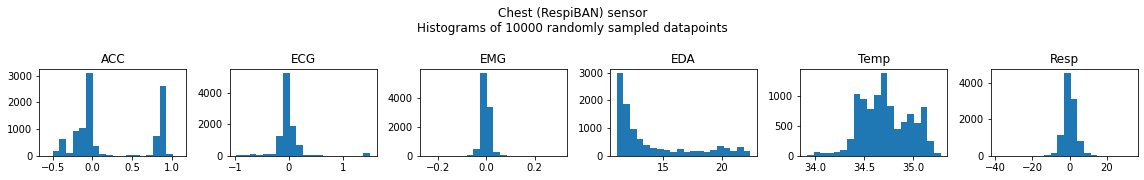


 Wrist (Empatica E4) sensor
ACC array has shape: (167616, 3) at 32 Hz for a total of  5238.0 seconds
BVP array has shape: (335232, 1) at 64 Hz for a total of  5238.0 seconds
EDA array has shape: (20952, 1) at 4 Hz for a total of  5238.0 seconds
TEMP array has shape: (20952, 1) at 4 Hz for a total of  5238.0 seconds


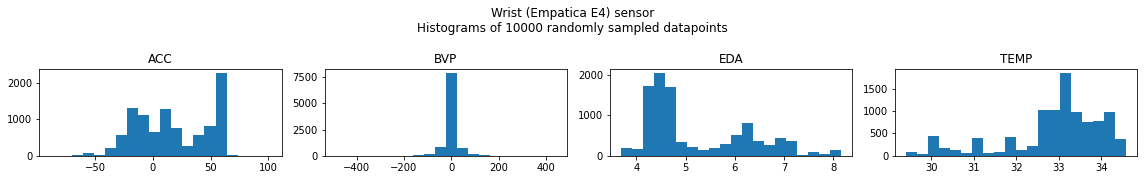


----------------------------------------------------------------------------



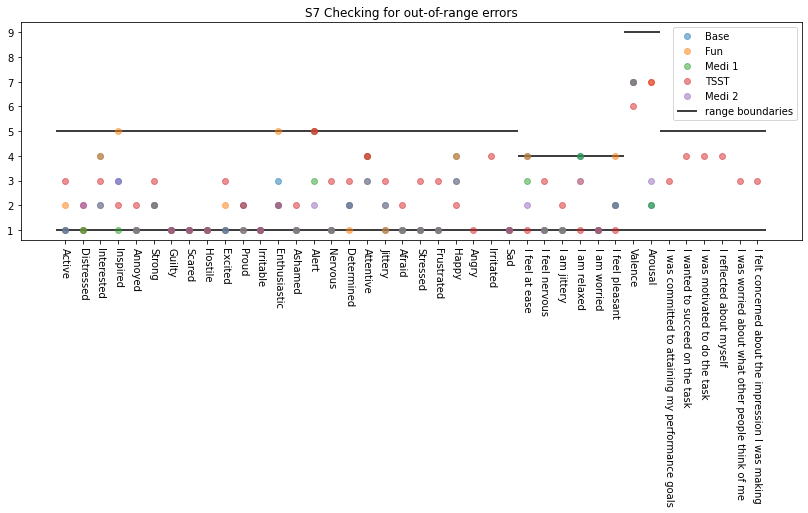


-------------------------------------------------------

S7 

Age : 28
Height (cm) : 184
Weight (kg) : 74
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : YES
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3826200
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S8


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


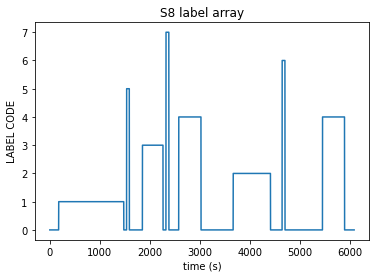



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3826200, 3) at 700 Hz for a total of  5466.0 seconds
ECG array has shape: (3826200, 1) at 700 Hz for a total of  5466.0 seconds
EMG array has shape: (3826200, 1) at 700 Hz for a total of  5466.0 seconds
EDA array has shape: (3826200, 1) at 700 Hz for a total of  5466.0 seconds
Temp array has shape: (3826200, 1) at 700 Hz for a total of  5466.0 seconds
Resp array has shape: (3826200, 1) at 700 Hz for a total of  5466.0 seconds


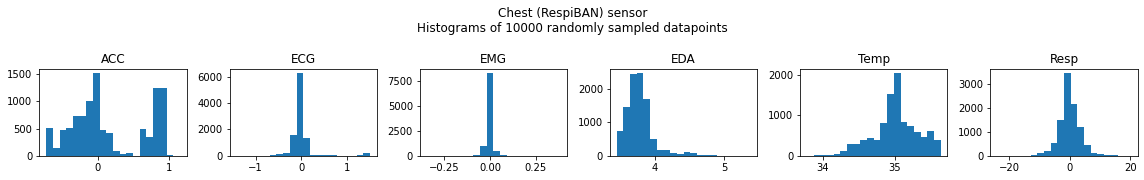


 Wrist (Empatica E4) sensor
ACC array has shape: (174912, 3) at 32 Hz for a total of  5466.0 seconds
BVP array has shape: (349824, 1) at 64 Hz for a total of  5466.0 seconds
EDA array has shape: (21864, 1) at 4 Hz for a total of  5466.0 seconds
TEMP array has shape: (21864, 1) at 4 Hz for a total of  5466.0 seconds


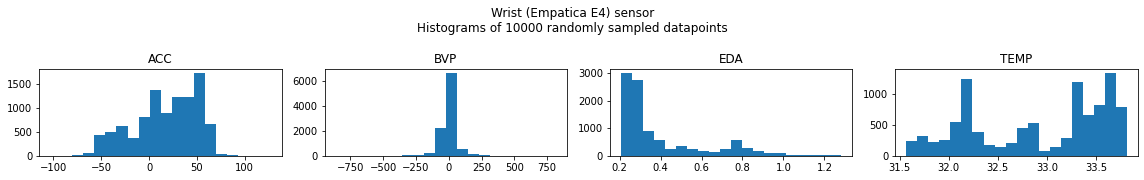


----------------------------------------------------------------------------



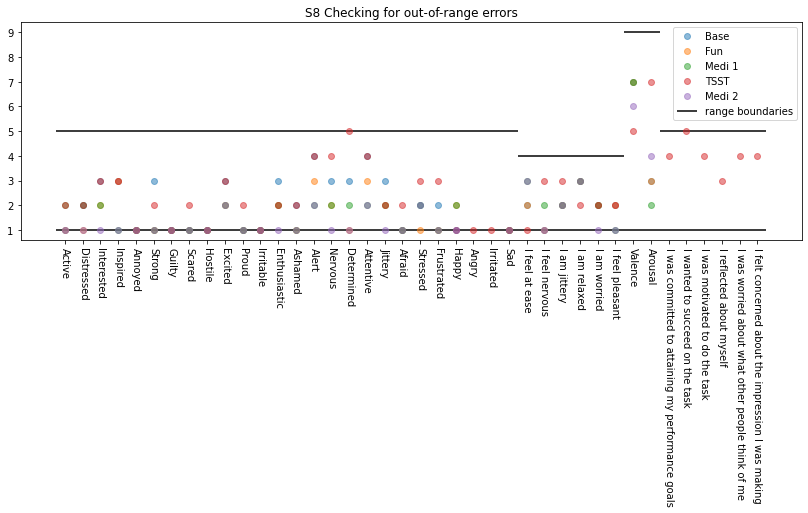


-------------------------------------------------------

S8 

Age : 27
Height (cm) : 172
Weight (kg) : 64
Gender : female
Dominant hand : left
Did you drink coffee today : YES
Did you drink coffee within the last hour : NO
Did you do any sports today : YES
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : Subject had already a rather stressful day, prior to the study.

LINE_18 : Subject felt rather cold in the room where the stress condition was carried out.


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3656100
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S9


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore

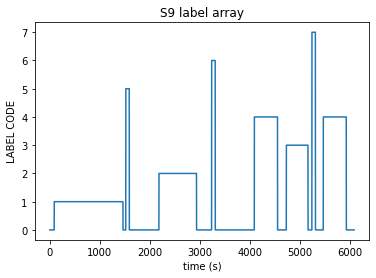



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3656100, 3) at 700 Hz for a total of  5223.0 seconds
ECG array has shape: (3656100, 1) at 700 Hz for a total of  5223.0 seconds
EMG array has shape: (3656100, 1) at 700 Hz for a total of  5223.0 seconds
EDA array has shape: (3656100, 1) at 700 Hz for a total of  5223.0 seconds
Temp array has shape: (3656100, 1) at 700 Hz for a total of  5223.0 seconds
Resp array has shape: (3656100, 1) at 700 Hz for a total of  5223.0 seconds


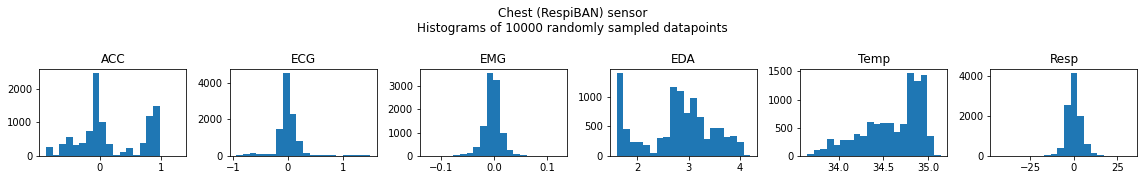


 Wrist (Empatica E4) sensor
ACC array has shape: (167136, 3) at 32 Hz for a total of  5223.0 seconds
BVP array has shape: (334272, 1) at 64 Hz for a total of  5223.0 seconds
EDA array has shape: (20892, 1) at 4 Hz for a total of  5223.0 seconds
TEMP array has shape: (20892, 1) at 4 Hz for a total of  5223.0 seconds


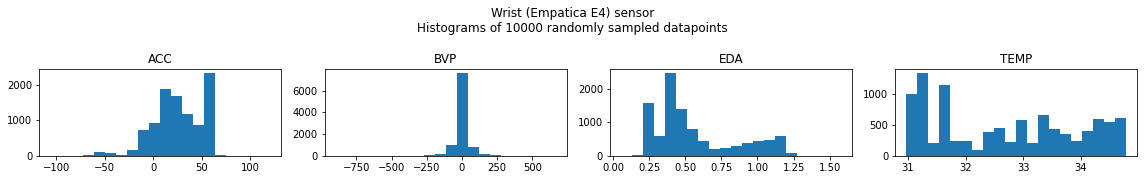


----------------------------------------------------------------------------



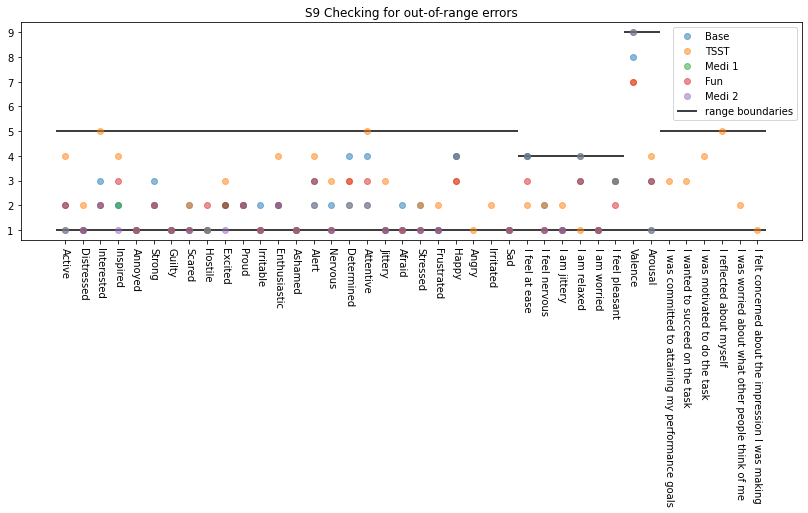


-------------------------------------------------------

S9 

Age : 26
Height (cm) : 181
Weight (kg) : 75
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : YES
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3847200
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S10


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


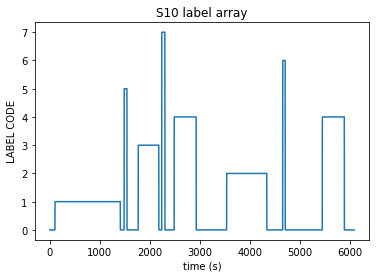



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3847200, 3) at 700 Hz for a total of  5496.0 seconds
ECG array has shape: (3847200, 1) at 700 Hz for a total of  5496.0 seconds
EMG array has shape: (3847200, 1) at 700 Hz for a total of  5496.0 seconds
EDA array has shape: (3847200, 1) at 700 Hz for a total of  5496.0 seconds
Temp array has shape: (3847200, 1) at 700 Hz for a total of  5496.0 seconds
Resp array has shape: (3847200, 1) at 700 Hz for a total of  5496.0 seconds


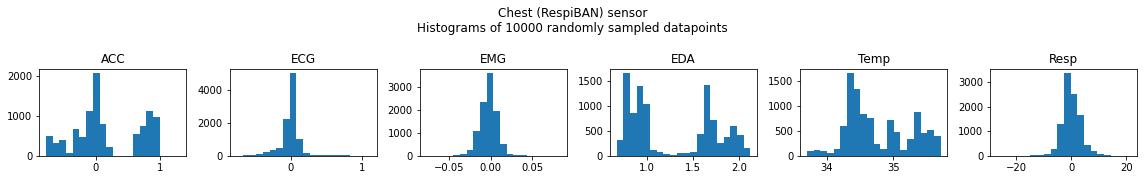


 Wrist (Empatica E4) sensor
ACC array has shape: (175872, 3) at 32 Hz for a total of  5496.0 seconds
BVP array has shape: (351744, 1) at 64 Hz for a total of  5496.0 seconds
EDA array has shape: (21984, 1) at 4 Hz for a total of  5496.0 seconds
TEMP array has shape: (21984, 1) at 4 Hz for a total of  5496.0 seconds


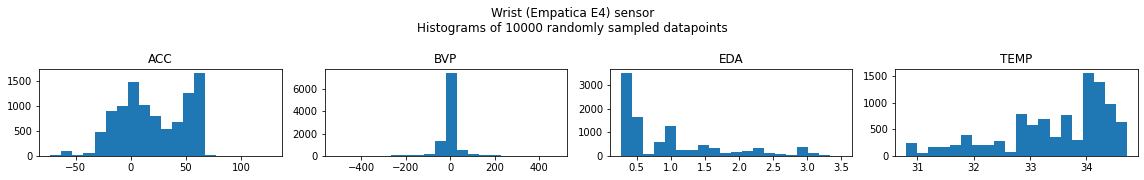


----------------------------------------------------------------------------



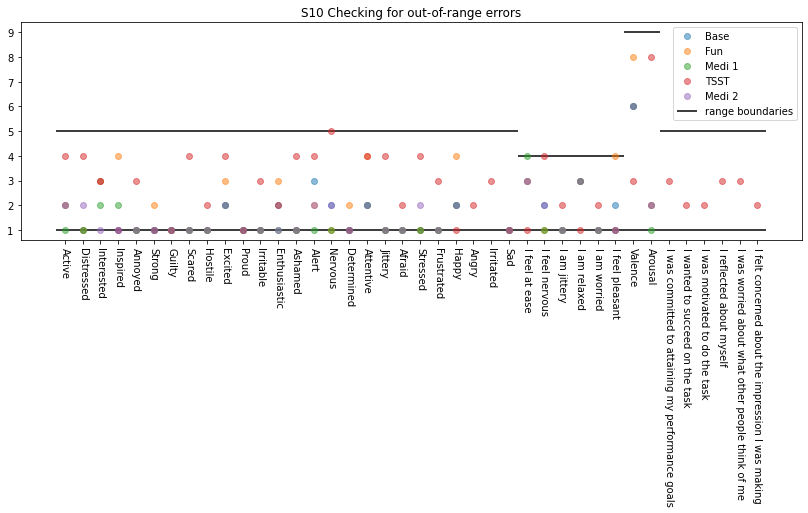


-------------------------------------------------------

S10 

Age : 28
Height (cm) : 178
Weight (kg) : 76
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3663100
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S11


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


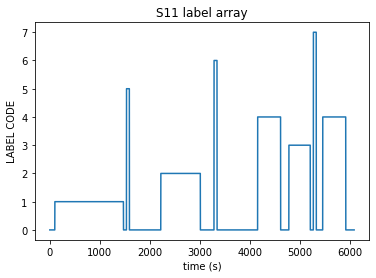



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3663100, 3) at 700 Hz for a total of  5233.0 seconds
ECG array has shape: (3663100, 1) at 700 Hz for a total of  5233.0 seconds
EMG array has shape: (3663100, 1) at 700 Hz for a total of  5233.0 seconds
EDA array has shape: (3663100, 1) at 700 Hz for a total of  5233.0 seconds
Temp array has shape: (3663100, 1) at 700 Hz for a total of  5233.0 seconds
Resp array has shape: (3663100, 1) at 700 Hz for a total of  5233.0 seconds


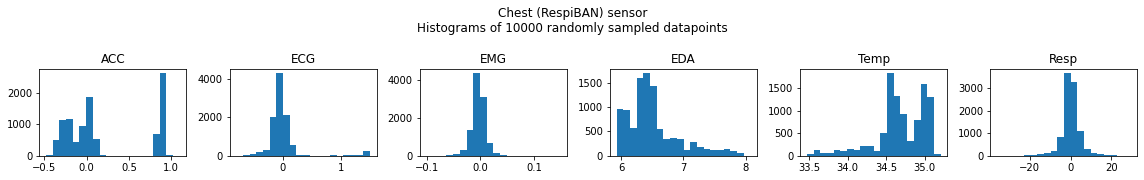


 Wrist (Empatica E4) sensor
ACC array has shape: (167456, 3) at 32 Hz for a total of  5233.0 seconds
BVP array has shape: (334912, 1) at 64 Hz for a total of  5233.0 seconds
EDA array has shape: (20932, 1) at 4 Hz for a total of  5233.0 seconds
TEMP array has shape: (20932, 1) at 4 Hz for a total of  5233.0 seconds


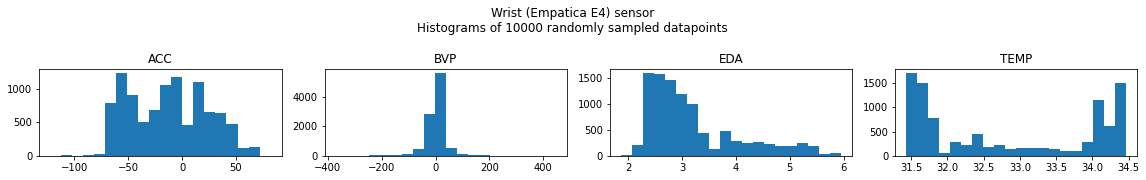


----------------------------------------------------------------------------



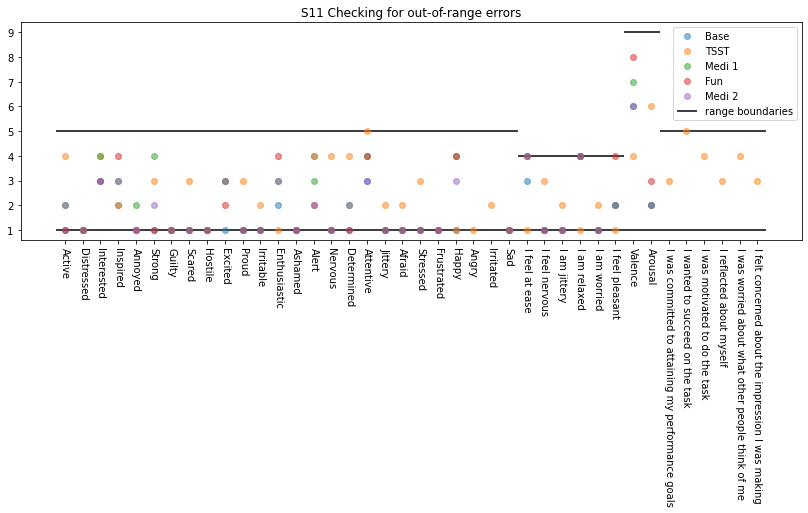


-------------------------------------------------------

S11 

Age : 26
Height (cm) : 171
Weight (kg) : 54
Gender : female
Dominant hand : right
Did you drink coffee today : YES
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3875900
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S13


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


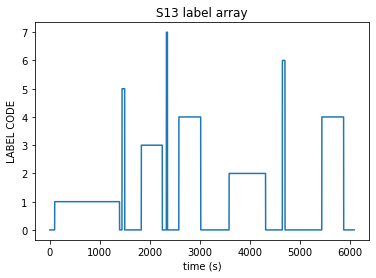



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3875900, 3) at 700 Hz for a total of  5537.0 seconds
ECG array has shape: (3875900, 1) at 700 Hz for a total of  5537.0 seconds
EMG array has shape: (3875900, 1) at 700 Hz for a total of  5537.0 seconds
EDA array has shape: (3875900, 1) at 700 Hz for a total of  5537.0 seconds
Temp array has shape: (3875900, 1) at 700 Hz for a total of  5537.0 seconds
Resp array has shape: (3875900, 1) at 700 Hz for a total of  5537.0 seconds


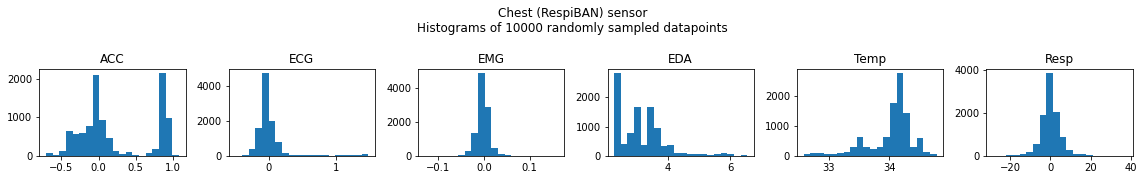


 Wrist (Empatica E4) sensor
ACC array has shape: (177184, 3) at 32 Hz for a total of  5537.0 seconds
BVP array has shape: (354368, 1) at 64 Hz for a total of  5537.0 seconds
EDA array has shape: (22148, 1) at 4 Hz for a total of  5537.0 seconds
TEMP array has shape: (22148, 1) at 4 Hz for a total of  5537.0 seconds


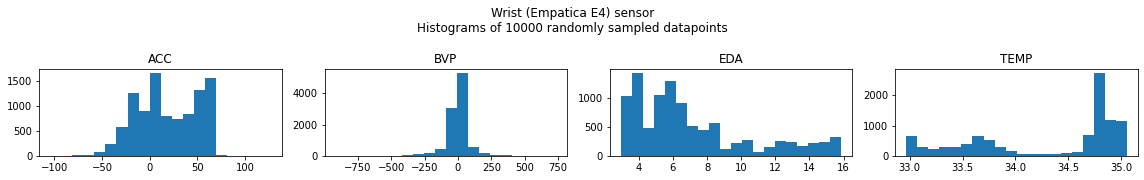


----------------------------------------------------------------------------



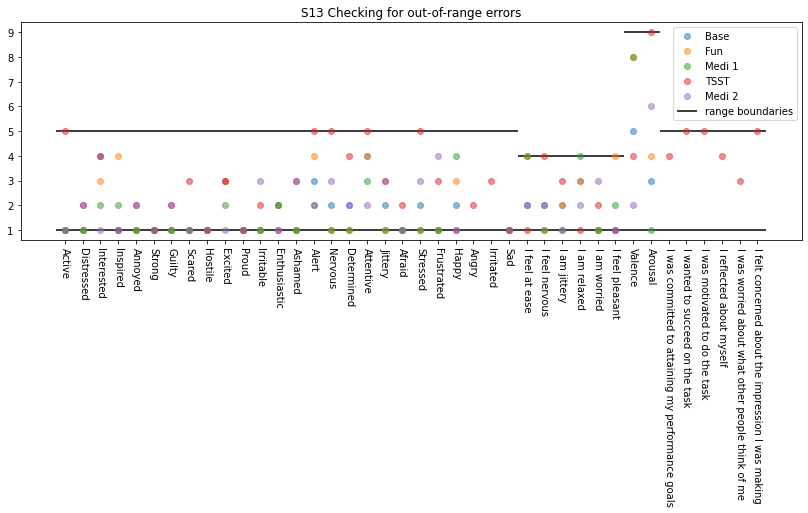


-------------------------------------------------------

S13 

Age : 28
Height (cm) : 181
Weight (kg) : 82
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3883600
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S14


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


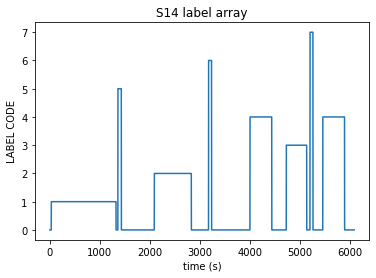



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3883600, 3) at 700 Hz for a total of  5548.0 seconds
ECG array has shape: (3883600, 1) at 700 Hz for a total of  5548.0 seconds
EMG array has shape: (3883600, 1) at 700 Hz for a total of  5548.0 seconds
EDA array has shape: (3883600, 1) at 700 Hz for a total of  5548.0 seconds
Temp array has shape: (3883600, 1) at 700 Hz for a total of  5548.0 seconds
Resp array has shape: (3883600, 1) at 700 Hz for a total of  5548.0 seconds


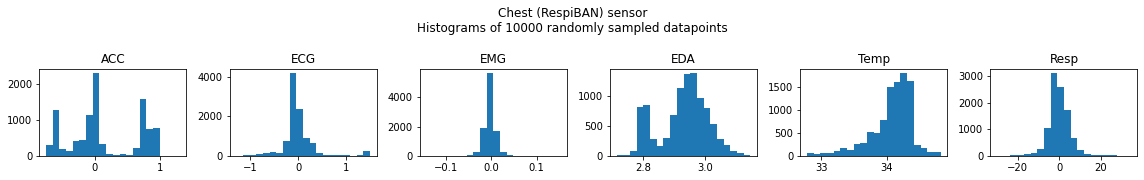


 Wrist (Empatica E4) sensor
ACC array has shape: (177536, 3) at 32 Hz for a total of  5548.0 seconds
BVP array has shape: (355072, 1) at 64 Hz for a total of  5548.0 seconds
EDA array has shape: (22192, 1) at 4 Hz for a total of  5548.0 seconds
TEMP array has shape: (22192, 1) at 4 Hz for a total of  5548.0 seconds


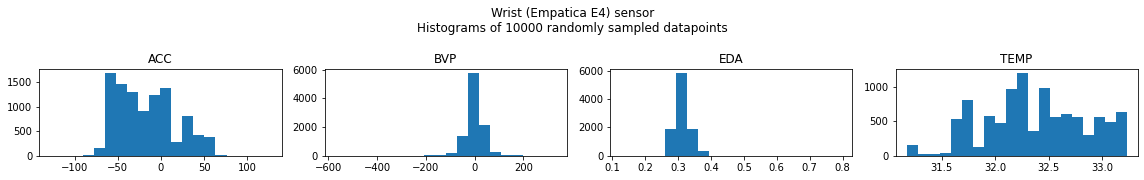


----------------------------------------------------------------------------



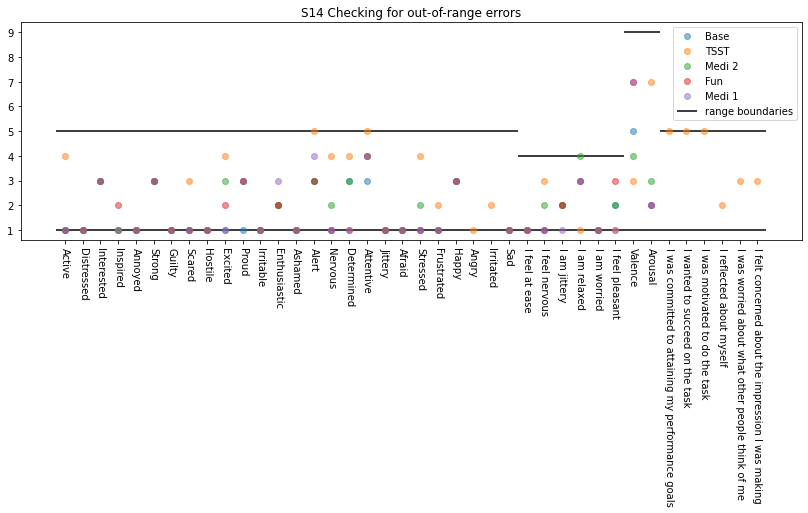


-------------------------------------------------------

S14 

Age : 27
Height (cm) : 180
Weight (kg) : 80
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : -


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3676400
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S15


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


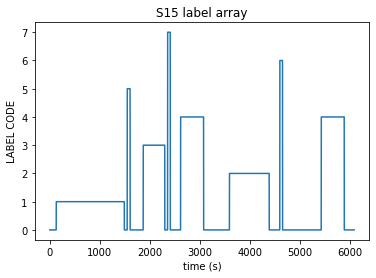



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3676400, 3) at 700 Hz for a total of  5252.0 seconds
ECG array has shape: (3676400, 1) at 700 Hz for a total of  5252.0 seconds
EMG array has shape: (3676400, 1) at 700 Hz for a total of  5252.0 seconds
EDA array has shape: (3676400, 1) at 700 Hz for a total of  5252.0 seconds
Temp array has shape: (3676400, 1) at 700 Hz for a total of  5252.0 seconds
Resp array has shape: (3676400, 1) at 700 Hz for a total of  5252.0 seconds


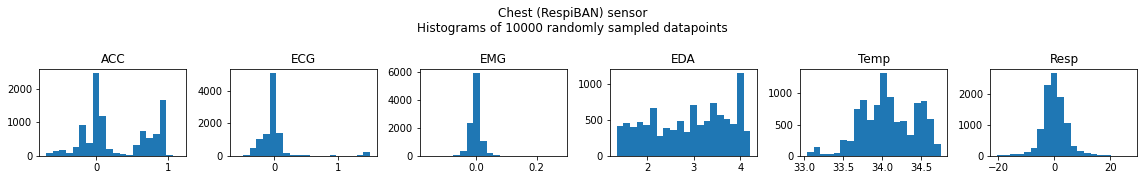


 Wrist (Empatica E4) sensor
ACC array has shape: (168064, 3) at 32 Hz for a total of  5252.0 seconds
BVP array has shape: (336128, 1) at 64 Hz for a total of  5252.0 seconds
EDA array has shape: (21008, 1) at 4 Hz for a total of  5252.0 seconds
TEMP array has shape: (21008, 1) at 4 Hz for a total of  5252.0 seconds


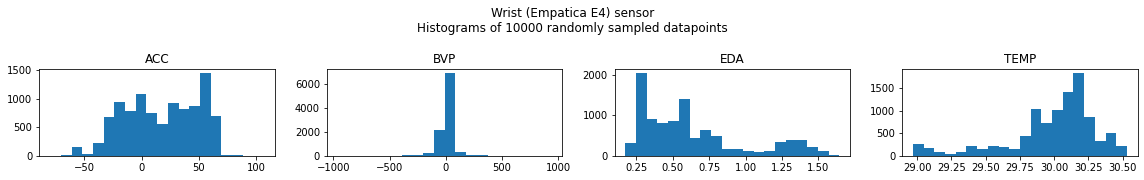


----------------------------------------------------------------------------



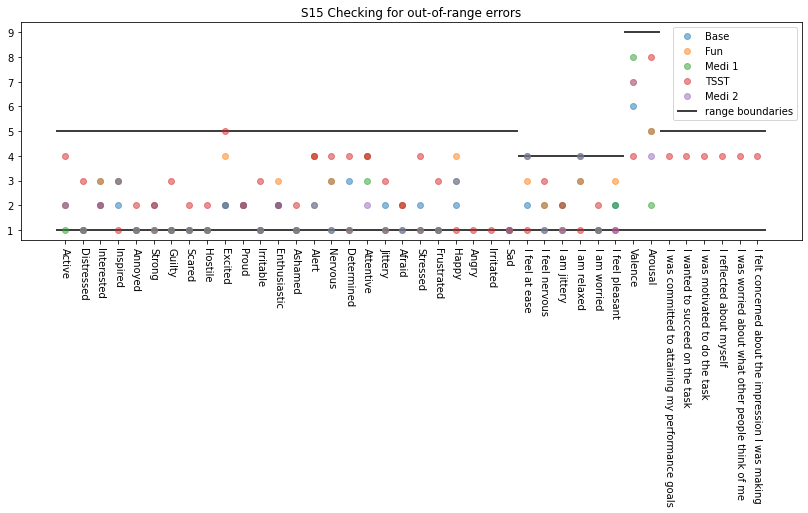


-------------------------------------------------------

S15 

Age : 28
Height (cm) : 186
Weight (kg) : 83
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : Subject didn't really believe the cover story of the stress condition (TSST).


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 3941700
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S16


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


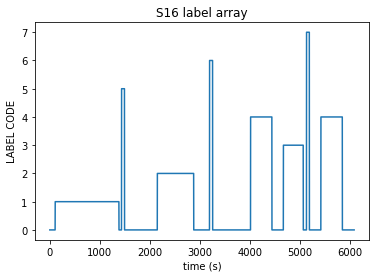



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (3941700, 3) at 700 Hz for a total of  5631.0 seconds
ECG array has shape: (3941700, 1) at 700 Hz for a total of  5631.0 seconds
EMG array has shape: (3941700, 1) at 700 Hz for a total of  5631.0 seconds
EDA array has shape: (3941700, 1) at 700 Hz for a total of  5631.0 seconds
Temp array has shape: (3941700, 1) at 700 Hz for a total of  5631.0 seconds
Resp array has shape: (3941700, 1) at 700 Hz for a total of  5631.0 seconds


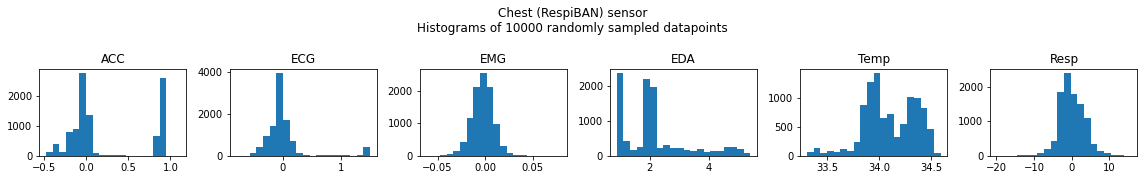


 Wrist (Empatica E4) sensor
ACC array has shape: (180192, 3) at 32 Hz for a total of  5631.0 seconds
BVP array has shape: (360384, 1) at 64 Hz for a total of  5631.0 seconds
EDA array has shape: (22524, 1) at 4 Hz for a total of  5631.0 seconds
TEMP array has shape: (22524, 1) at 4 Hz for a total of  5631.0 seconds


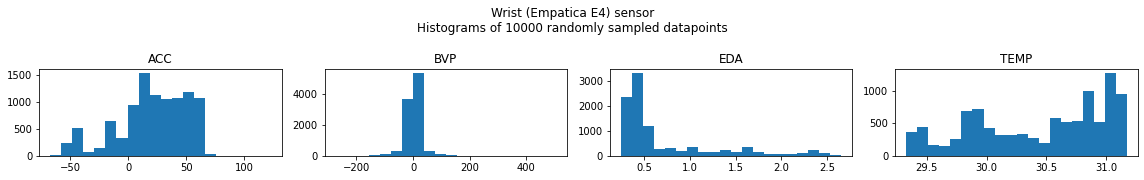


----------------------------------------------------------------------------



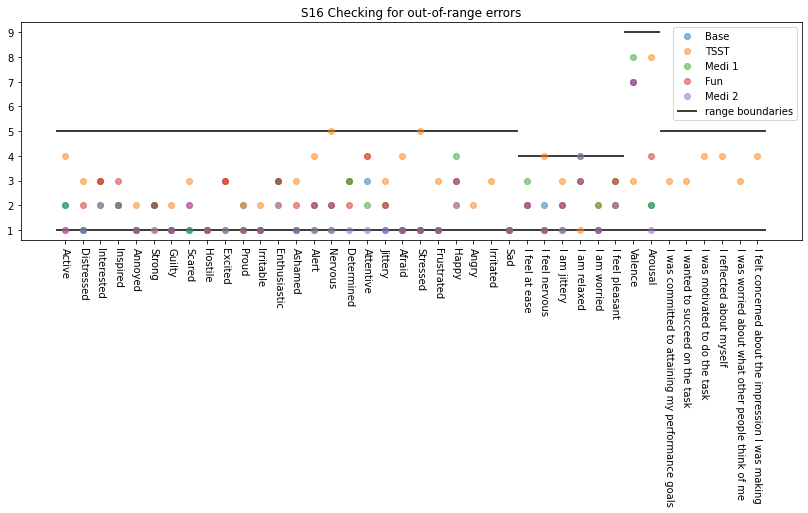


-------------------------------------------------------

S16 

Age : 24
Height (cm) : 184
Weight (kg) : 69
Gender : male
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : Subject felt rather cold in the room where the stress condition was carried out.


---------------------------------------------------------------

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4144000
subject  is type: <class 'str'>  with length: 3


SUBJECT #: S17


LABEL unique values: [0 1 2 3 4 5 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


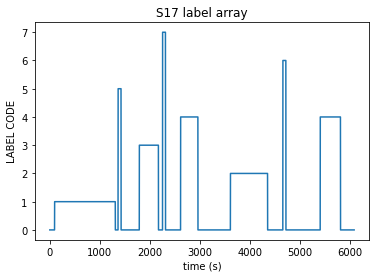



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4144000, 3) at 700 Hz for a total of  5920.0 seconds
ECG array has shape: (4144000, 1) at 700 Hz for a total of  5920.0 seconds
EMG array has shape: (4144000, 1) at 700 Hz for a total of  5920.0 seconds
EDA array has shape: (4144000, 1) at 700 Hz for a total of  5920.0 seconds
Temp array has shape: (4144000, 1) at 700 Hz for a total of  5920.0 seconds
Resp array has shape: (4144000, 1) at 700 Hz for a total of  5920.0 seconds


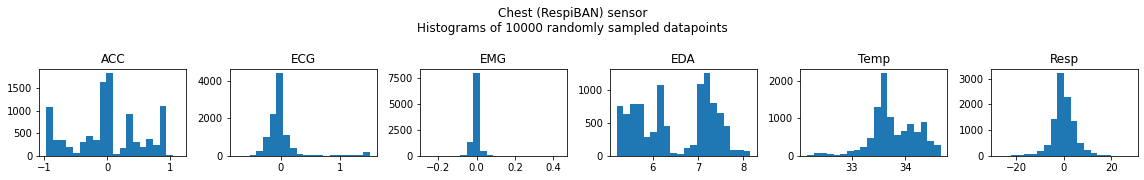


 Wrist (Empatica E4) sensor
ACC array has shape: (189440, 3) at 32 Hz for a total of  5920.0 seconds
BVP array has shape: (378880, 1) at 64 Hz for a total of  5920.0 seconds
EDA array has shape: (23680, 1) at 4 Hz for a total of  5920.0 seconds
TEMP array has shape: (23680, 1) at 4 Hz for a total of  5920.0 seconds


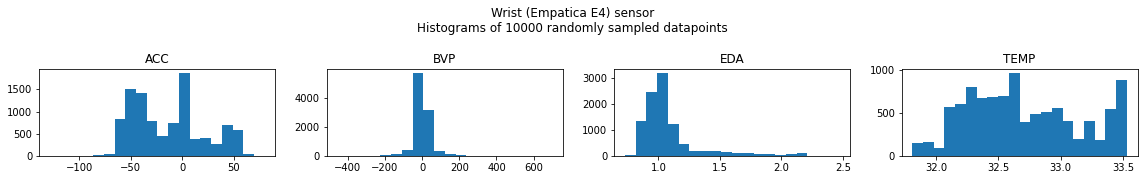


----------------------------------------------------------------------------



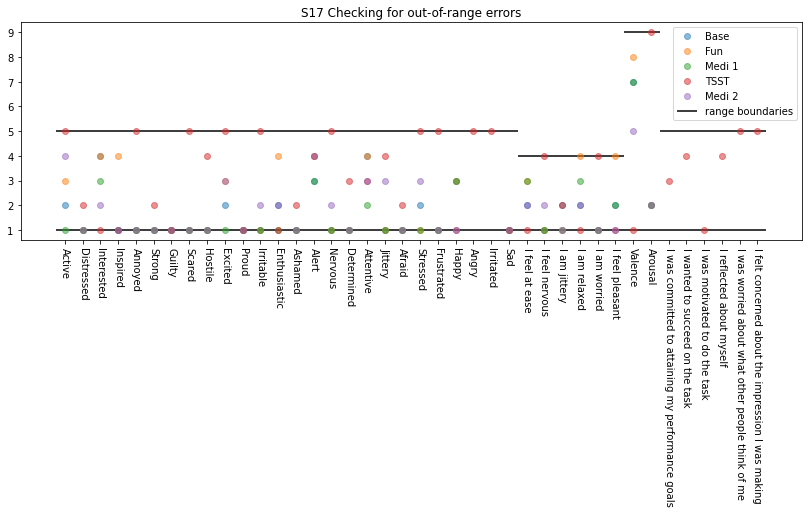


-------------------------------------------------------

S17 

Age : 29
Height (cm) : 165
Weight (kg) : 55
Gender : female
Dominant hand : right
Did you drink coffee today : NO
Did you drink coffee within the last hour : NO
Did you do any sports today : NO
Are you a smoker : NO
Did you smoke within the last hour : NO
Do you feel ill today : NO
LINE_17 : The RespiBAN temperature sensor was not fully attached throughout the entire duration of the study protocol.


---------------------------------------------------------------



In [170]:
# Check time-series, questionnaires, and subject info of all subjects
for S_ID in pkl_dict.keys():
    check_pkl_raw(S_ID, pkl_dict) #Default return_data=False
    process_questionnaires(S_ID, quest_dict) #Default return_df=False
    process_subject_info(S_ID, subjinfo_dict) #Default return_dict=False

Dictionary from .pkl file has keys: dict_keys(['signal', 'label', 'subject'])
signal  is type: <class 'dict'>  with length: 2
label  is type: <class 'numpy.ndarray'>  with length: 4255300
subject  is type: <class 'str'>  with length: 2


SUBJECT #: S2


LABEL unique values: [0 1 2 3 4 6 7]
{'0': 'not defined/transient', '1': 'baseline', '2': 'stress', '3': 'amusement', '4': 'meditation', '5': 'ignore', '6': 'ignore', '7': 'ignore'}


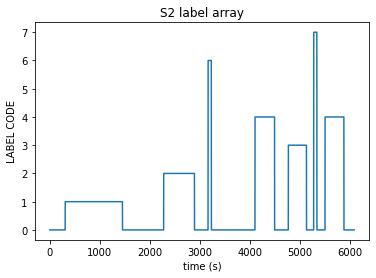



SIGNAL KEYS: dict_keys(['chest', 'wrist'])
chest: <class 'dict'> has keys: dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
wrist: <class 'dict'> has keys: dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])

 Chest (RespiBAN) sensor
ACC array has shape: (4255300, 3) at 700 Hz for a total of  6079.0 seconds
ECG array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
EMG array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
EDA array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
Temp array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds
Resp array has shape: (4255300, 1) at 700 Hz for a total of  6079.0 seconds


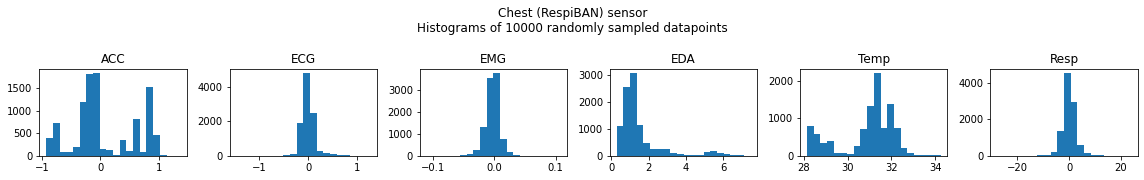


 Wrist (Empatica E4) sensor
ACC array has shape: (194528, 3) at 32 Hz for a total of  6079.0 seconds
BVP array has shape: (389056, 1) at 64 Hz for a total of  6079.0 seconds
EDA array has shape: (24316, 1) at 4 Hz for a total of  6079.0 seconds
TEMP array has shape: (24316, 1) at 4 Hz for a total of  6079.0 seconds


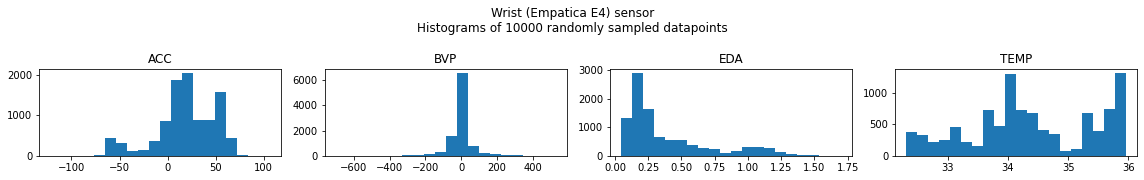


----------------------------------------------------------------------------

               ECG       EMG       EDA       Temp      Resp  label   ACC_x   ACC_y   ACC_z
0.000000  0.021423 -0.004440  5.250549  30.120758 -1.148987      0  0.9554 -0.2220 -0.5580
0.001429  0.020325  0.004349  5.267334  30.129517 -1.124573      0  0.9258 -0.2216 -0.5538
0.002857  0.016525  0.005173  5.243301  30.138214 -1.152039      0  0.9082 -0.2196 -0.5392
0.004286  0.016708  0.007187  5.249405  30.129517 -1.158142      0  0.8974 -0.2102 -0.5122
0.005714  0.011673 -0.015152  5.286407  30.130951 -1.161194      0  0.8882 -0.2036 -0.4824
<class 'pandas.core.frame.DataFrame'>
Float64Index: 4255300 entries, 0.0 to 6079.0
Data columns (total 9 columns):
 #   Column  Dtype  
---  ------  -----  
 0   ECG     float64
 1   EMG     float64
 2   EDA     float64
 3   Temp    float64
 4   Resp    float64
 5   label   int64  
 6   ACC_x   float64
 7   ACC_y   float64
 8   ACC_z   float64
dtypes: float64(8), int64(1)


In [182]:
S2_sensor_dict = check_pkl_raw('S2', pkl_dict, return_data=True)
time_index = np.linspace(0,6079, len(S2_sensor_dict['signal']['chest']['ECG']) )
chest_df = pd.DataFrame({key: list(S2_sensor_dict['signal']['chest'][key]) for key in ['ECG', 'EMG', 'EDA', 'Temp', 'Resp']}, index=time_index).astype('float')
chest_df = pd.concat([chest_df, pd.Series(list(S2_sensor_dict['label']), name='label', index=time_index)], axis=1)
chest_df = pd.concat([chest_df, pd.DataFrame({ 'ACC_x':list(S2_sensor_dict['signal']['chest']['ACC'][:,0]), 'ACC_y':list(S2_sensor_dict['signal']['chest']['ACC'][:,1]), 'ACC_z':list(S2_sensor_dict['signal']['chest']['ACC'][:,2]) }, index=time_index).astype('float') ], axis=1 )
print(chest_df.head())
print(chest_df.info())

In [186]:
# PLOTTING WRIST CHANNELS

# formula for calculating time center of sample:
# 0.25 sampling period has a centers of 0.125, 0.375, ..., end_time - 0.375, end_time - 0.125
# np.linspace( sp/2 , end - (sp/2) , len(signal_array) ) # Where sp is sampling period
# sp = 1/sf # Where sf is sampling frequency
# sf = Hz_dict[key]

def plot_wrist_channels(raw_pkl_dictionary, xlims = (0, 1), title=''):
    """
    Plots the channels from the Empatica 4 on the subjects wrist
    Inputs:: 
    raw_pkl_dictionary: dictionary directly from original pkl file
    xlims: x-limits for plotting
    """
    Hz_dict = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4} # Frequency for Wrist device channels
    fig, axes = plt.subplots(6,1,figsize=[14,12])
    fig.suptitle(title)
    #How big should the markers be?
    if xlims[1]-xlims[0] < 2 : markers = 'o'
    elif xlims[1]-xlims[0] < 10 : markers = '.'
    else : markers = ''
        
    for key, signal in raw_pkl_dictionary['signal']['wrist'].items():
        sf = Hz_dict[key]
        sp = 1/sf
        time_points = np.linspace( sp/2 , 6079 - (sp/2) , signal.shape[0] )

        if key=='ACC':
            ACC_x = signal[:,0]
            ACC_y = signal[:,1]
            ACC_z = signal[:,2]

            for ax, acc, c, name in zip(axes[:3], [ACC_x, ACC_y, ACC_z], ['r','g','b'], ['ACC_x', 'ACC_y', 'ACC_z']):
                ax.plot(time_points, acc, color=c, marker=markers, label=name)
                #ax.hlines(y=[p for p in acc[:100]], xmin=[t-(sp/2) for t in time_points[:100]], xmax=[t+(sp/2) for t in time_points[:100]], color='k', linewidth=2)
                ax.set_xlim(*xlims)
                ax.legend(loc = 'upper right')
            #plt.show()
        else:
            if key=='BVP': ax = axes[3]
            elif key=='EDA': ax = axes[4]
            elif key=='TEMP': ax = axes[5]
            ax.plot(time_points, signal, marker=markers, label=key)
            #plt.hlines(y=[p for p in signal[:100]], xmin=[t-(sp/2) for t in time_points[:100]], xmax=[t+(sp/2) for t in time_points[:100]], color='k', linewidth=2)
            ax.set_xlim(*xlims)
            ax.legend(loc = 'upper right')
    plt.show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

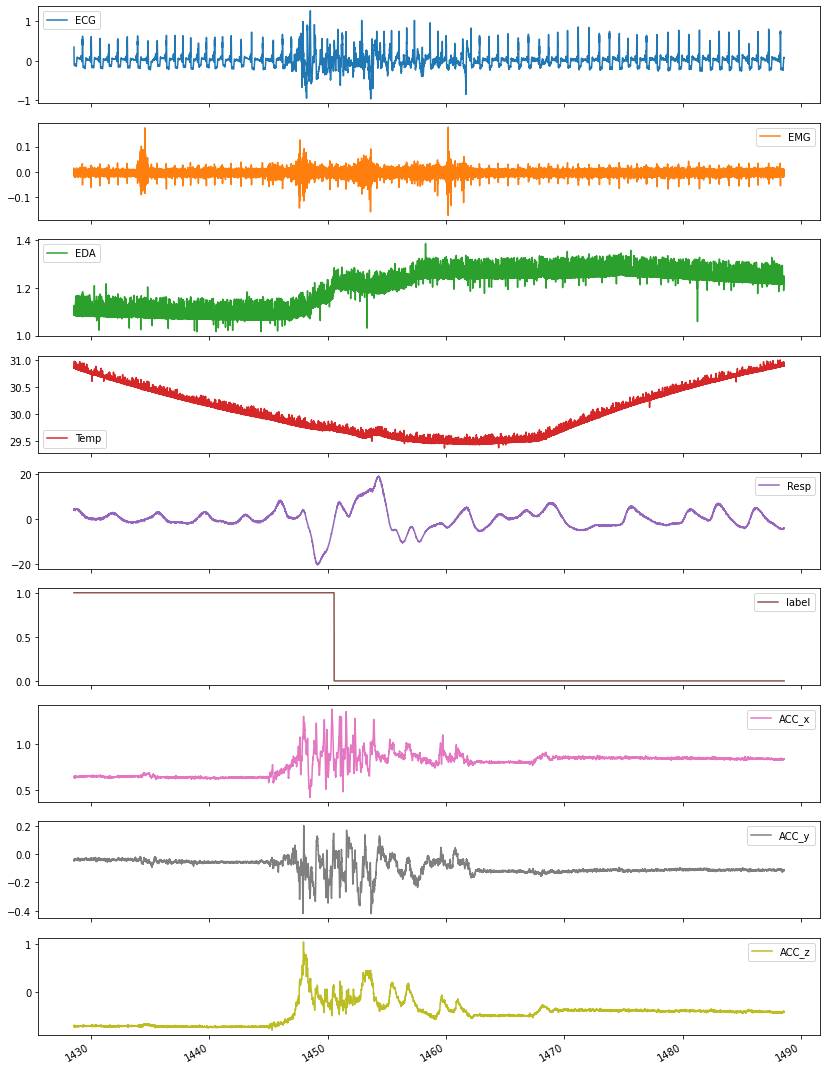

In [184]:
chest_df.iloc[1000000:1042000,:].plot(subplots=True, figsize=[14,21]) #FULL MINUTE DURING BASELINE

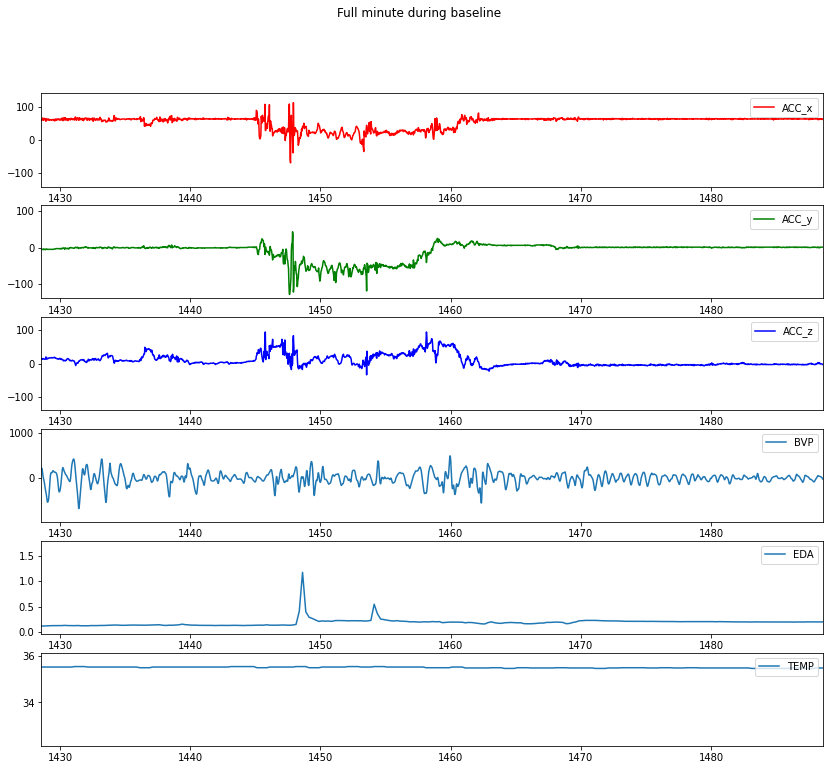

In [187]:
plot_wrist_channels(S2_sensor_dict, (1000000/700, 1042000/700), 'Full minute during baseline')

# Overall conclusions:
## Most channels appear to be helpful, although they will all require some type of preprocessing
## BVP may be unhelpful (poor signal to noise ratio)
## TEMP measures appear to be unreliable
## ACC (accelerometer) is less noisy on wrist device than chest device
## Self-report data is high quality